In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.mlab as mlab
import glob
from scipy import optimize

In [12]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def find_vals(X,Y,cut):
    dataX = X[cut:]
    dataY = Y[cut:]
    minn = min(dataY)
    sig_val = minn*0.5
    MeanLoc = np.where(dataY==minn)[0][0]
    Mean = dataX[MeanLoc]
    L = dataY[0:MeanLoc]
    R = dataY[MeanLoc:len(dataY)]
    LP =find_nearest(L,sig_val)
    RP =find_nearest(R,sig_val)
    whereL = np.where(L==LP)[0][0]
    whereR = np.where(R==RP)[0][0]
    Lpoint = dataX[whereL]
    Rpoint = dataX[MeanLoc+whereR]
    FWHM = (Rpoint-Lpoint)   
    return (Mean,FWHM)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [13]:
def gaussian(x, height, center, width):
    return height*np.exp(-(x - center)**2/(2*width**2))

def SignalCut(X,Y):
    TriggerTime = find_nearest(Xhot,0)
    Trigger     = np.where(Xhot==TriggerTime)[0][0]
    Cut = Trigger+100
    minPulseHold = find_nearest(Yhot,min(Yhot[2*Cut:]))
    minPulse     = np.where(Yhot==minPulseHold)[0][0]
    SignalCut = Cut + (minPulse-Cut)/2
    return int(SignalCut)

def gauss_fit_vals_N(X,Y,N):
    minn    = min(Y)
    MeanLoc = np.where(Y==minn)[0][0]
    Mean    = X[MeanLoc]
    width   = 20
    Dmean   = np.linspace(0,150,N,endpoint=True)
    Dheight = np.linspace(1,0,N+1,endpoint=True)
    H = []
    W = []
    M = []
    for x in range(0,N):
        H.append(minn*Dheight[x])
        W.append(20)
        M.append(Mean+Dmean[x])
    FitVals = []
    boundsA  = []
    boundsB  = []
    for x in range(0,N):
        FitVals.append(H[x]) 
        FitVals.append(M[x])
        FitVals.append(W[x])
        boundsA.append(-1000), boundsA.append(0), boundsA.append(0) 
        boundsB.append(0), boundsB.append(600), boundsB.append(100) 
        #bounds.append([(-1,0),(0,600),(10,100)]) # [(H),(M),(W)]
    #return H, M, W
    return np.array(FitVals), (boundsA,boundsB)

def N_gaussians(x, VALS, N):
    func = np.zeros(len(x))
    fiting = np.reshape(VALS,(N,3))
    for q in range(0,N):
        func+=gaussian(x, fiting[q][0], fiting[q][1], fiting[q][2])
    
    return func



def Fit_N_gaussians(X,Y,N):
    CUT = SignalCut(X,Y)
    FitVals ,Bound = gauss_fit_vals_N(Xhot[CUT:],Yhot[CUT:],N)
    errfunc = lambda p, x, y: (N_gaussians(x, p, N) - y)**2
    pp = optimize.least_squares(errfunc, FitVals,bounds=Bound, args=(Xhot[CUT:],Yhot[CUT:]))
    return pp.x
    
def Chi(X,Y,N):
    Chi = []
    NN = list(range(1,N+1))
    for q in NN:
        OP = Fit_N_gaussians(X,Y,q)
        E = N_gaussians(X,OP,q)
        O = Y
        dof = len(O)-1-3*q
        chi = np.sum((O-E)**2/sigma**2)/dof
        Chi.append(chi)
    return Chi


In [14]:
cd /Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/A250-long

/Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/A250-long


In [15]:
#PATH = '/Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/090418-cleaned-2bar/'
files = glob.glob('*.txt')
#files.remove('.DS_Store')
files.sort()
files[-1]

'waveform-155.txt'

In [16]:
ml = 1e3
Hold = np.loadtxt('waveform-122.txt')
Xhot = Hold[0]*ml
Yhot = Hold[1]*ml


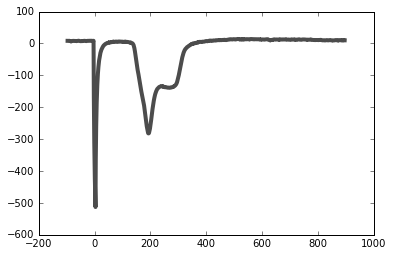

In [17]:
plt.plot(Xhot,Yhot,color='k',linewidth=4,alpha=0.7,label='data')


In [31]:
FitVals ,Bound = gauss_fit_vals_N(Xhot,Yhot,1)

In [36]:
Bound

([-1000, 0, 0], [0, 600, 100])

In [35]:
Fit_N_gaussians(Xhot,Yhot,1)

array([-214.67453044,  214.49136461,   50.53496124])

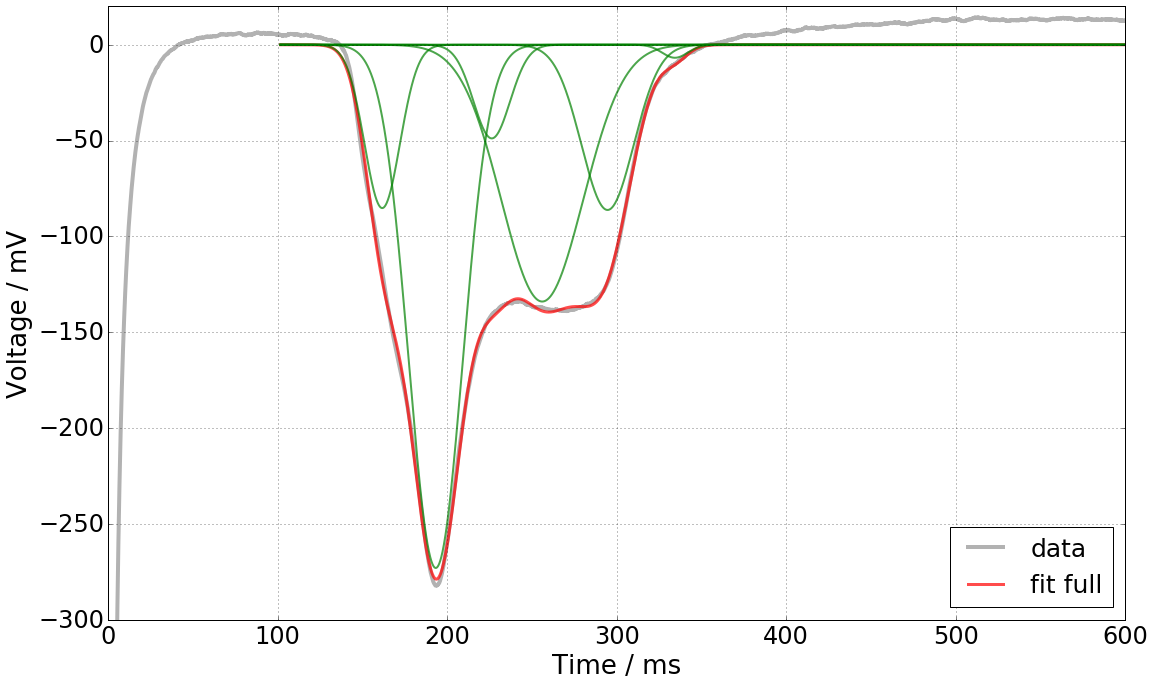

In [19]:
CUT = SignalCut(Xhot,Yhot)
plt.figure(figsize=(15,9))
aw = 6
plt.plot(Xhot,Yhot,color='k',linewidth=4,alpha=0.3,label='data')
OP = Fit_N_gaussians(Xhot,Yhot,aw)
OP = np.reshape(OP,(aw,3))
plt.plot(Xhot[CUT:],N_gaussians(Xhot[CUT:],OP,aw),'r',label='fit full',lw=3,alpha=0.7)

for q in range(0,aw):
    y1 = gaussian(Xhot[CUT:],*OP[q])
    plt.plot(Xhot[CUT:],y1,'g',lw=2,alpha=0.7)


plt.xlim(0,600)
plt.ylim(-300,20)
plt.grid()
plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [18]:
sigma = 0.9191676436091325
CH = Chi(Xhot,Yhot,10)

In [19]:
min(CH)
np.where(CH==min(CH))

(array([5]),)

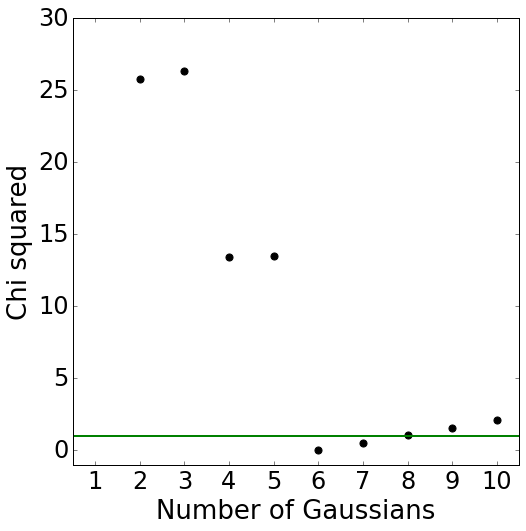

In [37]:
plt.figure(figsize=(8,8))

X = list(range(1,10+1))
plt.scatter(X,CH-min(CH),s=50,color='k')
plt.ylim(-1,30)
plt.xlim(0.5,10.5)
plt.xticks(X)

plt.xlabel(r'Number of Gaussians',fontsize=26)
plt.ylabel('Chi squared',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.axhline(1,lw=2,color='g')

plt.show()